In [ ]:
import glob as glob
import numpy as np
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt

In [63]:
def get_ClusterClient(
        ncores=1,
        nmem='25GB',
        walltime='01:00:00',
        account='UWAS0155'):
    """
    Code from Daniel Kennedy
    More info about Dask on HPC - https://ncar.github.io/dask-tutorial/notebooks/05-dask-hpc.html
    """
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client

    cluster = PBSCluster(
        cores=ncores,              # The number of cores you want
        memory=nmem,               # Amount of memory
        processes=ncores,          # How many processes
        queue='casper',            # Queue name
        resource_spec='select=1:ncpus=' +\
        str(ncores)+':mem='+nmem,  # Specify resources
        account=account,           # Input your project ID here
        walltime=walltime,         # Amount of wall time
        interface='ext',           # Interface to use
    )

    client = Client(cluster)
    return cluster, client


## Create Dask cluster and client, scale up to 20 workers
if "cluster" not in globals():
    cluster, client = get_ClusterClient(nmem="5GB")
    cluster.scale(10)

    ## Wait for cluster to be set up
    import time
    time.sleep(5)

## Check the status of the cluster
print(client)

## Prints the PBS job script that is used to submit the Dask workers
# print(cluster.job_script())

## Lists active workers and their status
print(cluster.workers)

## Lists current jobs in Casper queue
# !qstat -x -u $USER

## Create the SSH tunnel to access the Dask dashboard locally
port = cluster.dashboard_link.split(":")[2].split("/")[0]
address = cluster.dashboard_link.split(":")[1][2:]
print(f"ssh -N -L {port}:{address}:{port} bbuchovecky@casper.hpc.ucar.edu")  # local command line argument
print(f"http://localhost:{port}/status")  # link to local dask dashboard

/glade/u/home/bbuchovecky/miniforge3/envs/cpl_ppe_co2/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45261 instead
  warnings.warn(


<Client: 'tcp://128.117.211.222:34353' processes=0 threads=0, memory=0 B>
{'PBSCluster-7': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-4': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-9': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-1': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-3': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-6': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-8': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-2': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-5': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>}
ssh -N -L 45261:128.117.211.222:45261 bbuchovecky@casper.hpc.ucar.edu
http://localhost:45261/status


In [64]:
def _shift_time(da):
    if (da.time[0].dt.month.item() == 2) and (da.time[-1].dt.month.item() == 1):
        new_time = xr.date_range(
            start=str(da.time[0].dt.year.item()) + "-01",
            end=str(da.time[-1].dt.year.item() - 1) + "-12",
            freq="MS",
            calendar="noleap",
            use_cftime=True,
        )
        return da.assign_coords(time=new_time)
    return da


def _get_chunk_size_from_res(case):
    if "f09_f09" in case:
        chunk_size = {"time": 1024}
    else:
        chunk_size = {"time": 2048}
    return chunk_size


def _single_var(varname, case, basedir, domain="lnd", htape="h0"):
    def keep_var(ds):
        return ds[[varname]]

    component = {
        "lnd": "clm2",
        "atm": "cam",
    }

    data = xr.open_mfdataset(
        f"{basedir}/{case}/{domain}/hist/{case}.{component[domain]}.{htape}.*.nc",
        combine="by_coords",
        decode_timedelta=False,
        parallel=True,
        preprocess=keep_var,
        chunks=_get_chunk_size_from_res(case),
        engine="netcdf4",
    )[varname]

    return _shift_time(data)


def get_single_var(varname, cases, basedir, get_area=[]):
    data = dict()
    for case in cases:
        if isinstance(case, list):
            print("  ", case[0])
            data_list = []
            for c in case:
                data_list.append(_single_var(varname, c, basedir))
            data[case[0]] = xr.concat(data_list, dim="time").chunk(_get_chunk_size_from_res(case[0]))

        else:
            print("  ", case)
            data[case] = _single_var(varname, case, basedir).chunk(_get_chunk_size_from_res(case))

    if isinstance(get_area, str):
        files = glob.glob(f"{basedir}/{get_area}/lnd/hist/*.clm2.h0.*")
        if len(files) > 0:
            area = xr.open_dataset(files[0], decode_timedelta=False)["area"] * 1000000
            landfrac = xr.open_dataset(files[0], decode_timedelta=False)["landfrac"]
            landarea = (area * landfrac).fillna(0)
            return data, landarea
        print(f"could not retrieve area from {basedir}")

    return data


djk_basedir = "/glade/derecho/scratch/djk2120/archive/"
djk_cases = [
    [
        "f.e21.FHIST_BGC.f09_f09.ersstv5.cplhist",
        "f.e21.FHIST_BGC.f09_f09.ersstv5.cplhist.ext",
    ],
]

bgb_basedir = "/glade/derecho/scratch/bbuchovecky/archive"
bgb_cases = [
    "f.e21.FHIST_BGC.f19_f19_mg17.coupPPE-hist.cplhist",
    "f.e21.FHIST_BGC.f19_f19_mg17.historical.coupPPE.cplhist",
]

output = dict()
variables = [
    "TLAI",
    "EFLX_LH_TOT",
    "TOTSOMC",
    "TOTVEGC"
]
for v in variables:
    print(v)
    bgb_output, la_deg2 = get_single_var(
        v, bgb_cases, bgb_basedir, "f.e21.FHIST_BGC.f19_f19_mg17.coupPPE-hist.cplhist"
    )
    djk_output, la_deg1 = get_single_var(
        v, djk_cases, djk_basedir, "f.e21.FHIST_BGC.f09_f09.ersstv5.cplhist"
    )
    output[v] = {**bgb_output, **djk_output}

TLAI
   f.e21.FHIST_BGC.f19_f19_mg17.coupPPE-hist.cplhist
   f.e21.FHIST_BGC.f19_f19_mg17.historical.coupPPE.cplhist
   f.e21.FHIST_BGC.f09_f09.ersstv5.cplhist
EFLX_LH_TOT
   f.e21.FHIST_BGC.f19_f19_mg17.coupPPE-hist.cplhist
   f.e21.FHIST_BGC.f19_f19_mg17.historical.coupPPE.cplhist
   f.e21.FHIST_BGC.f09_f09.ersstv5.cplhist
TOTSOMC
   f.e21.FHIST_BGC.f19_f19_mg17.coupPPE-hist.cplhist
   f.e21.FHIST_BGC.f19_f19_mg17.historical.coupPPE.cplhist
   f.e21.FHIST_BGC.f09_f09.ersstv5.cplhist
TOTVEGC
   f.e21.FHIST_BGC.f19_f19_mg17.coupPPE-hist.cplhist
   f.e21.FHIST_BGC.f19_f19_mg17.historical.coupPPE.cplhist
   f.e21.FHIST_BGC.f09_f09.ersstv5.cplhist


In [65]:
goga_dir = "/glade/campaign/collections/rda/data/d651010/global/CESM2.1_GOGA_ERSSTv5"
goga_case = "f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.ens"

for v in variables:
    output[v][goga_case] = []
    for i in range(10):
        goga_tmp = xr.open_mfdataset(
            f"{goga_dir}/lnd/proc/tseries/month_1/{v.upper()}/{goga_case}{str(i+1).zfill(2)}.clm2.h0.{v.upper()}.*.nc",
            combine="by_coords",
            decode_timedelta=False,
            parallel=True,
            chunks={"time": 512},
            engine="netcdf4",
        )[v.upper()].chunk(_get_chunk_size_from_res(goga_case))
        output[v][goga_case].append(_shift_time(goga_tmp))
    output[v][goga_case] = xr.concat(output[v][goga_case], dim="member").assign_coords({"member": np.arange(10)})

In [66]:
cmip_dir = "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/"
amip_case = "f.e21.FHIST_BGC.f19_f19_mg17.CMIP6-AMIP-2deg"
bhist_case = "b.e21.BHIST.f19_g17.CMIP6-historical-2deg"

for case in [amip_case, bhist_case]:
    for v in variables:
        output[v][case] = []
        for i in range(3):
            da_tmp = xr.open_mfdataset(
                f"{cmip_dir}/{case}.{str(i+1).zfill(3)}/lnd/proc/tseries/month_1/{case}.{str(i+1).zfill(3)}.clm2.h0.{v.upper()}.*.nc",
                combine="by_coords",
                decode_timedelta=False,
                parallel=True,
                chunks={"time": 1024},
                engine="netcdf4",
            )[v.upper()].chunk(_get_chunk_size_from_res(case))
            output[v][case].append(_shift_time(da_tmp))
        output[v][case] = xr.concat(output[v][case], dim="member").assign_coords({"member": np.arange(3)})

In [74]:
12/7

1.7142857142857142

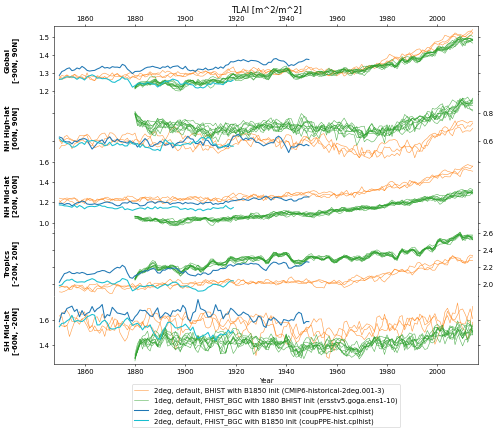

In [77]:
# Define latitude bands
lat_bands = [
    (-90, 90, "Global"),
    (60, 90, "NH High-lat"),
    (20, 60, "NH Mid-lat"),
    (-20, 20, "Tropics"),
    (-60, -20, "SH Mid-lat"),
]

nlat = len(lat_bands)
srtyr = 1850
endyr = 2014
v = "TLAI"

# Create stacked subplots
fig, axes = plt.subplots(
    nlat, 1,
    height_ratios=[1]*nlat,
    figsize=(10, 1.75*nlat), dpi=50,
    layout="tight",
    gridspec_kw={"hspace":0},
    sharex=True)

for idx, (lat_1, lat_2, lat_label) in enumerate(lat_bands):
    ax = axes[idx]

    for i in range(3):
        label = None
        if i == 0:
            label = "2deg, default, BHIST with B1850 init (CMIP6-historical-2deg.001-3)"
        output[v]["b.e21.BHIST.f19_g17.CMIP6-historical-2deg"].sel(member=i, lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label=label, c="tab:orange", lw=0.8, alpha=0.8)

    for i in range(10):
        label = None
        if i == 0:
            label = "1deg, default, FHIST_BGC with 1880 BHIST init (ersstv5.goga.ens1-10)"
        output[v]["f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.ens"].sel(member=i, lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg1).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label=label, c="tab:green", lw=0.8, alpha=0.8)

    output[v]["f.e21.FHIST_BGC.f19_f19_mg17.coupPPE-hist.cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label="2deg, default, FHIST_BGC with B1850 init (coupPPE-hist.cplhist)",  c="tab:blue")
    output[v]["f.e21.FHIST_BGC.f19_f19_mg17.historical.coupPPE.cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label="2deg, default, FHIST_BGC with B1850 init (coupPPE-hist.cplhist)",  c="tab:cyan")
    
    ax.set_ylabel("")
    ax.set_xlim(srtyr-2, endyr+2)
    ax.yaxis.set_ticks_position('both')

    ax.text(x=-0.1, y=0.5, s=f"{lat_label}\n[{lat_1}N, {lat_2}N]", fontweight="bold", ha="center", va="center", rotation=90, transform=ax.transAxes)

    if idx%2 == 1:
        ax.yaxis.set_label_position("right")
        ax.tick_params(axis='y', which='both', labelleft=False, labelright=True)
    if idx > 0:
        ax.spines["top"].set_visible(False)
    if idx < nlat - 1:
        ax.set_xlabel("")
        ax.spines["bottom"].set_visible(False)
    if idx == 0:
        ax.xaxis.set_ticks_position('top')
        ax.set_title(f"{v} [m^2/m^2]", fontsize=12)

axes[-1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), bbox_transform=axes[-1].transAxes)
axes[-1].set_xlabel("Year")
plt.show()

now = dt.datetime.strftime(dt.datetime.now(), "%y%m%d")
fig.savefig(f"cplhist_{v}_{now}.png", dpi=300)

'251110'

datetime.datetime(2025, 11, 10, 11, 44, 53, 196652)

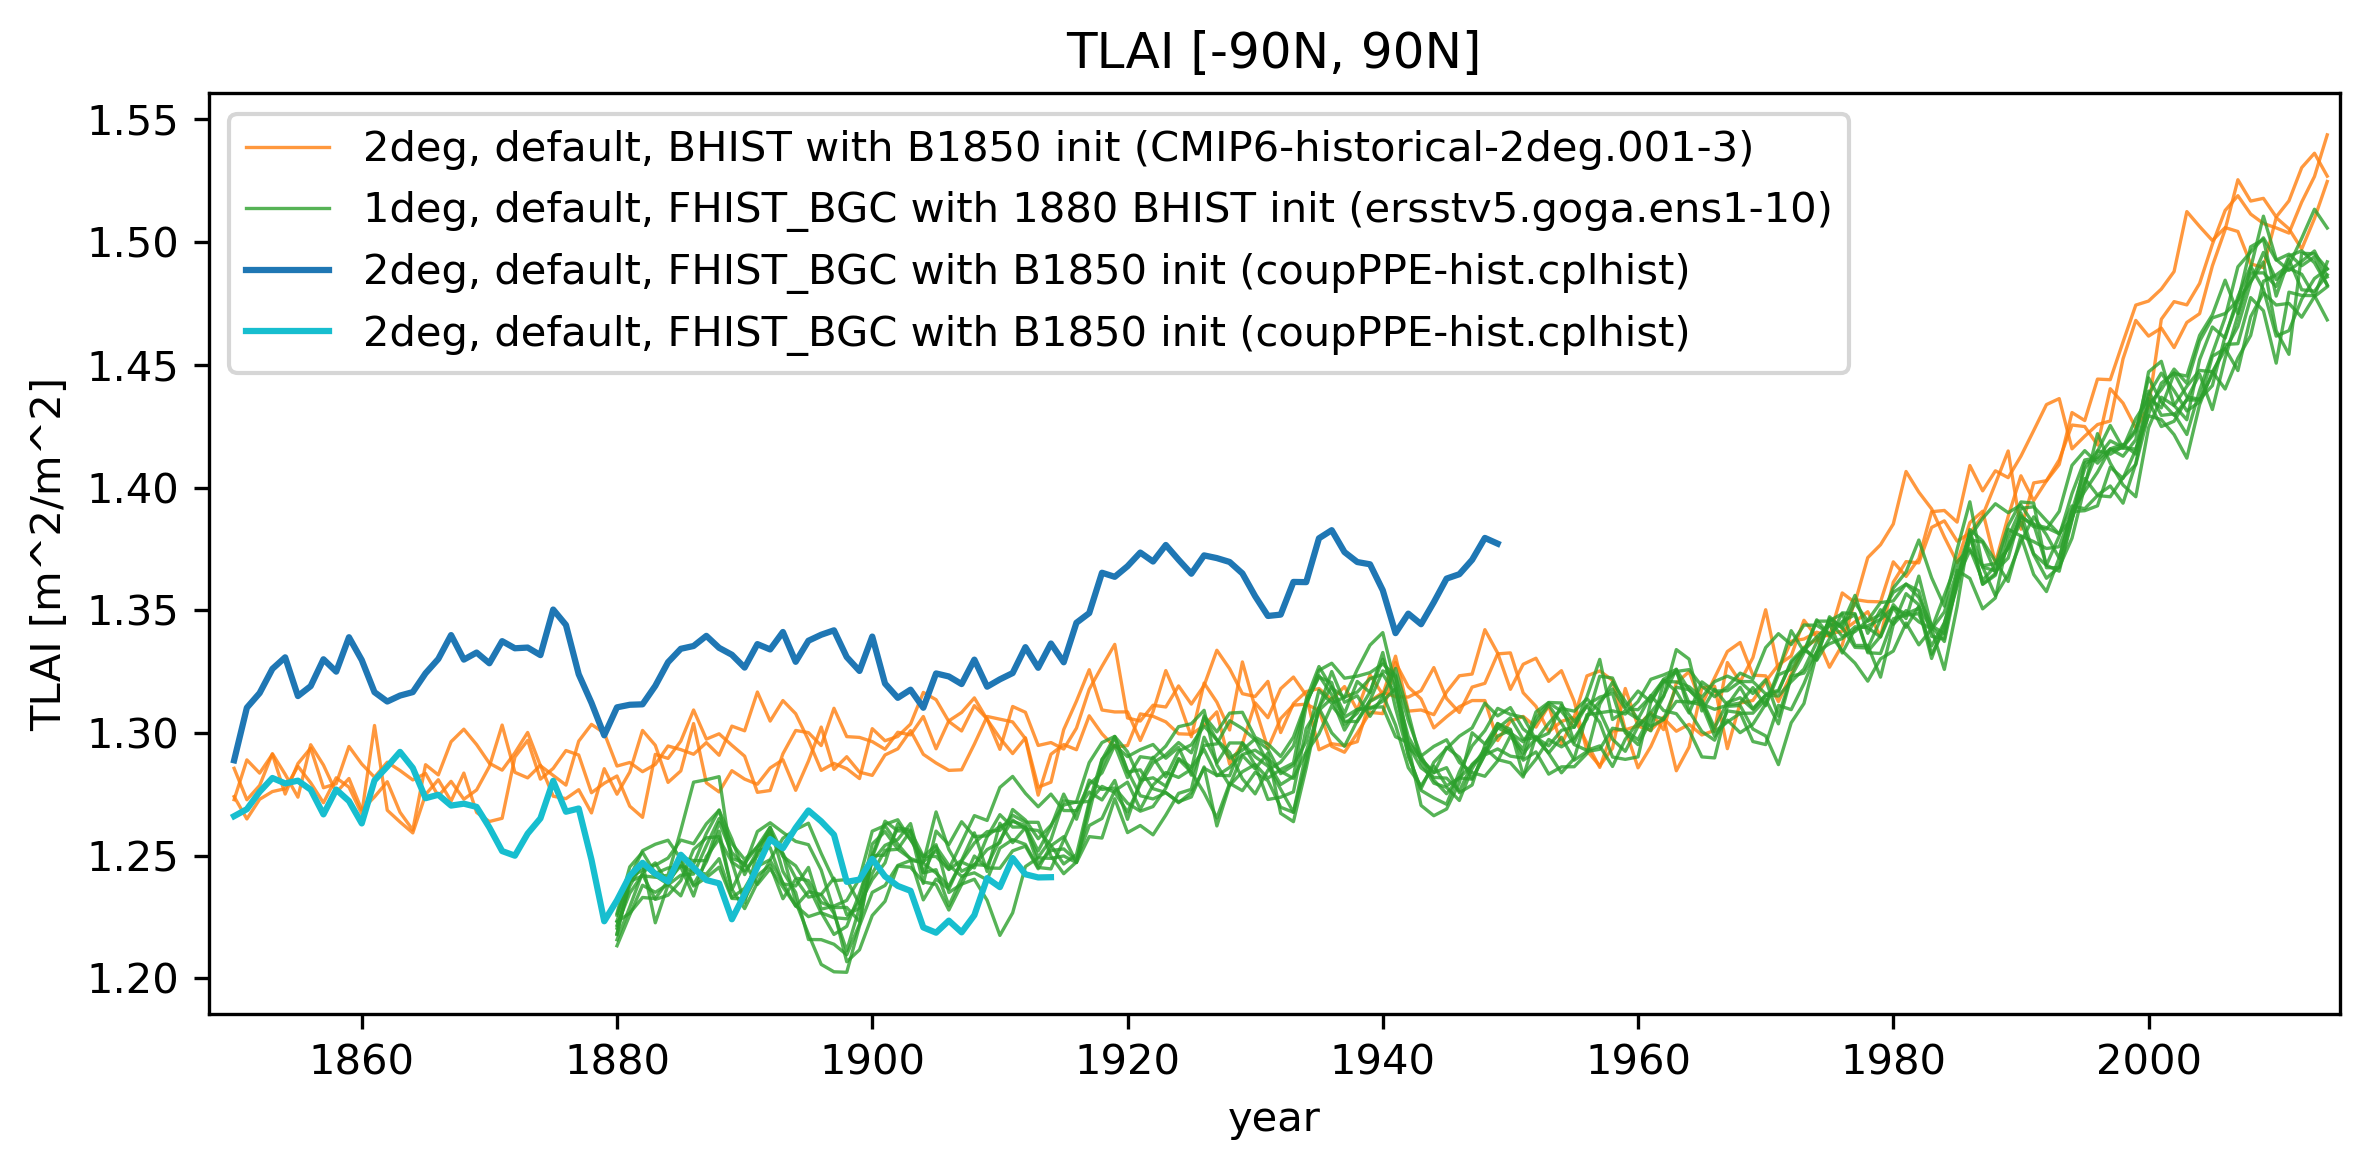

In [ ]:
lat_1 = -90
lat_2 = 90

srtyr = 1850
endyr = 2014

v = "TLAI"

fig, ax = plt.subplots(figsize=(8, 4), dpi=300, layout="tight")

for i in range(3):
    label = None
    if i == 0:
        label = "2deg, default, BHIST with B1850 init (CMIP6-historical-2deg.001-3)"
    output[v]["b.e21.BHIST.f19_g17.CMIP6-historical-2deg"].sel(member=i, lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label=label, c="tab:orange", lw=0.8, alpha=0.8)

for i in range(10):
    label = None
    if i == 0:
        label = "1deg, default, FHIST_BGC with 1880 BHIST init (ersstv5.goga.ens1-10)"
    output[v]["f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.ens"].sel(member=i, lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg1).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label=label, c="tab:green", lw=0.8, alpha=0.8)

output[v]["f.e21.FHIST_BGC.f19_f19_mg17.coupPPE-hist.cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label="2deg, default, FHIST_BGC with B1850 init (coupPPE-hist.cplhist)",  c="tab:blue")
output[v]["f.e21.FHIST_BGC.f19_f19_mg17.historical.coupPPE.cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label="2deg, default, FHIST_BGC with B1850 init (coupPPE-hist.cplhist)",  c="tab:cyan")

ax.set_xlim(srtyr-2, endyr+2)
ax.set_ylabel("TLAI [m^2/m^2]")
ax.set_title(f"{v} [{lat_1}N, {lat_2}N]")
ax.legend()

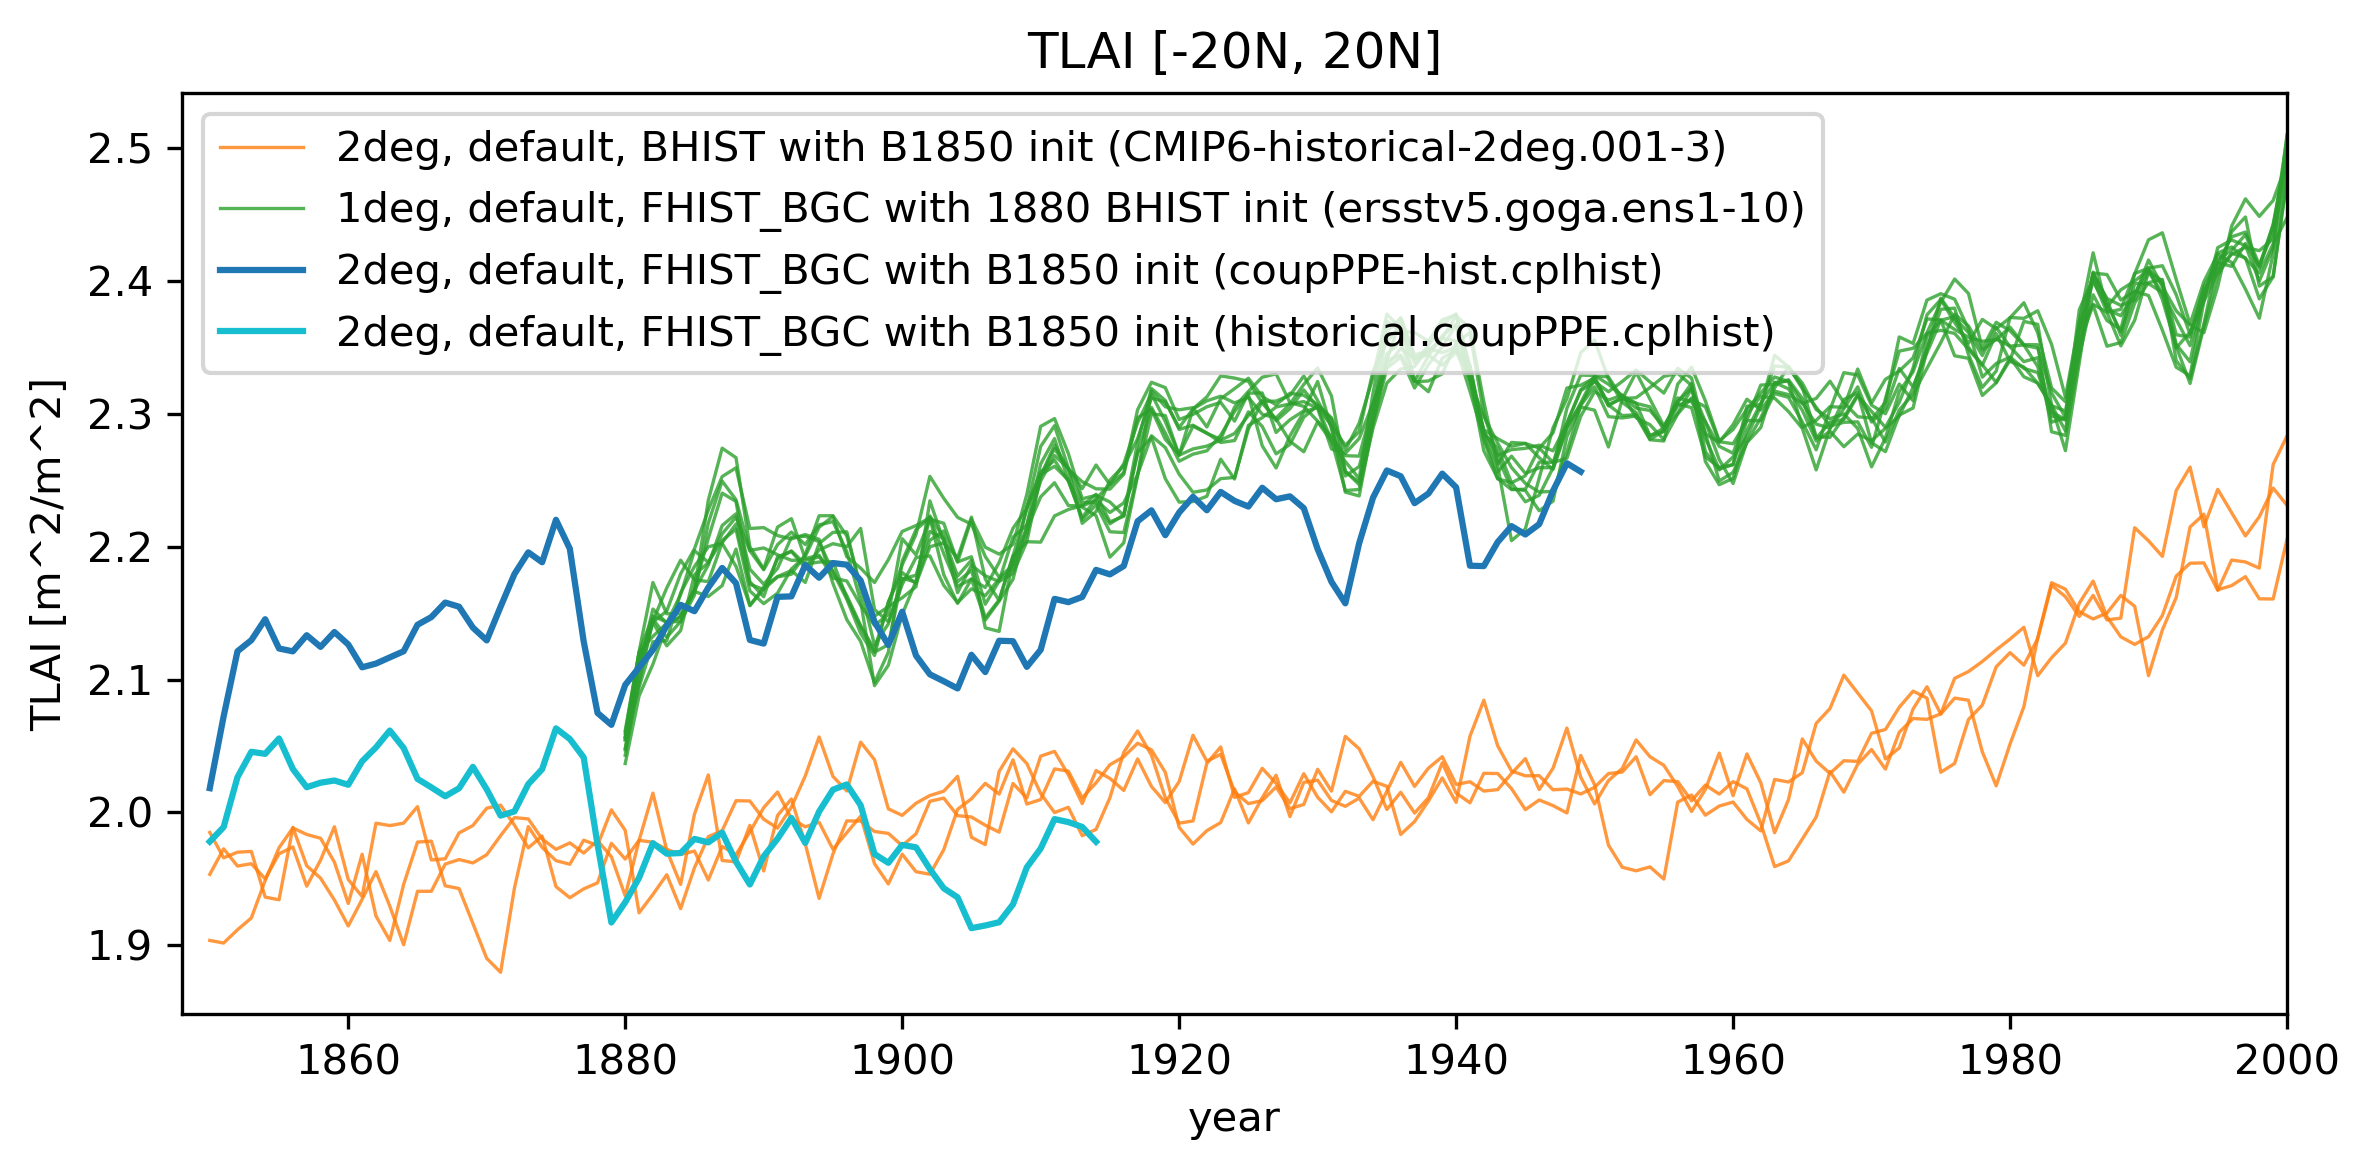

In [12]:
lat_1 = -20
lat_2 = 20

srtyr = 1850
endyr = 2000

v = "TLAI"

fig, ax = plt.subplots(figsize=(8, 4), dpi=300, layout="tight")

for i in range(3):
    label = None
    if i == 0:
        label = "2deg, default, BHIST with B1850 init (CMIP6-historical-2deg.001-3)"
    output[v]["b.e21.BHIST.f19_g17.CMIP6-historical-2deg"].sel(member=i, lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label=label, c="tab:orange", lw=0.8, alpha=0.8)

for i in range(10):
    label = None
    if i == 0:
        label = "1deg, default, FHIST_BGC with 1880 BHIST init (ersstv5.goga.ens1-10)"
    output[v]["f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.ens"].sel(member=i, lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg1).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label=label, c="tab:green", lw=0.8, alpha=0.8)

output[v]["f.e21.FHIST_BGC.f19_f19_mg17.coupPPE-hist.cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label="2deg, default, FHIST_BGC with B1850 init (coupPPE-hist.cplhist)",  c="tab:blue")
output[v]["f.e21.FHIST_BGC.f19_f19_mg17.historical.coupPPE.cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label="2deg, default, FHIST_BGC with B1850 init (historical.coupPPE.cplhist)",  c="tab:cyan")

ax.set_xlim(srtyr-2, endyr)
ax.set_ylabel("TLAI [m^2/m^2]")
ax.set_title(f"{v} [{lat_1}N, {lat_2}N]")
ax.legend()

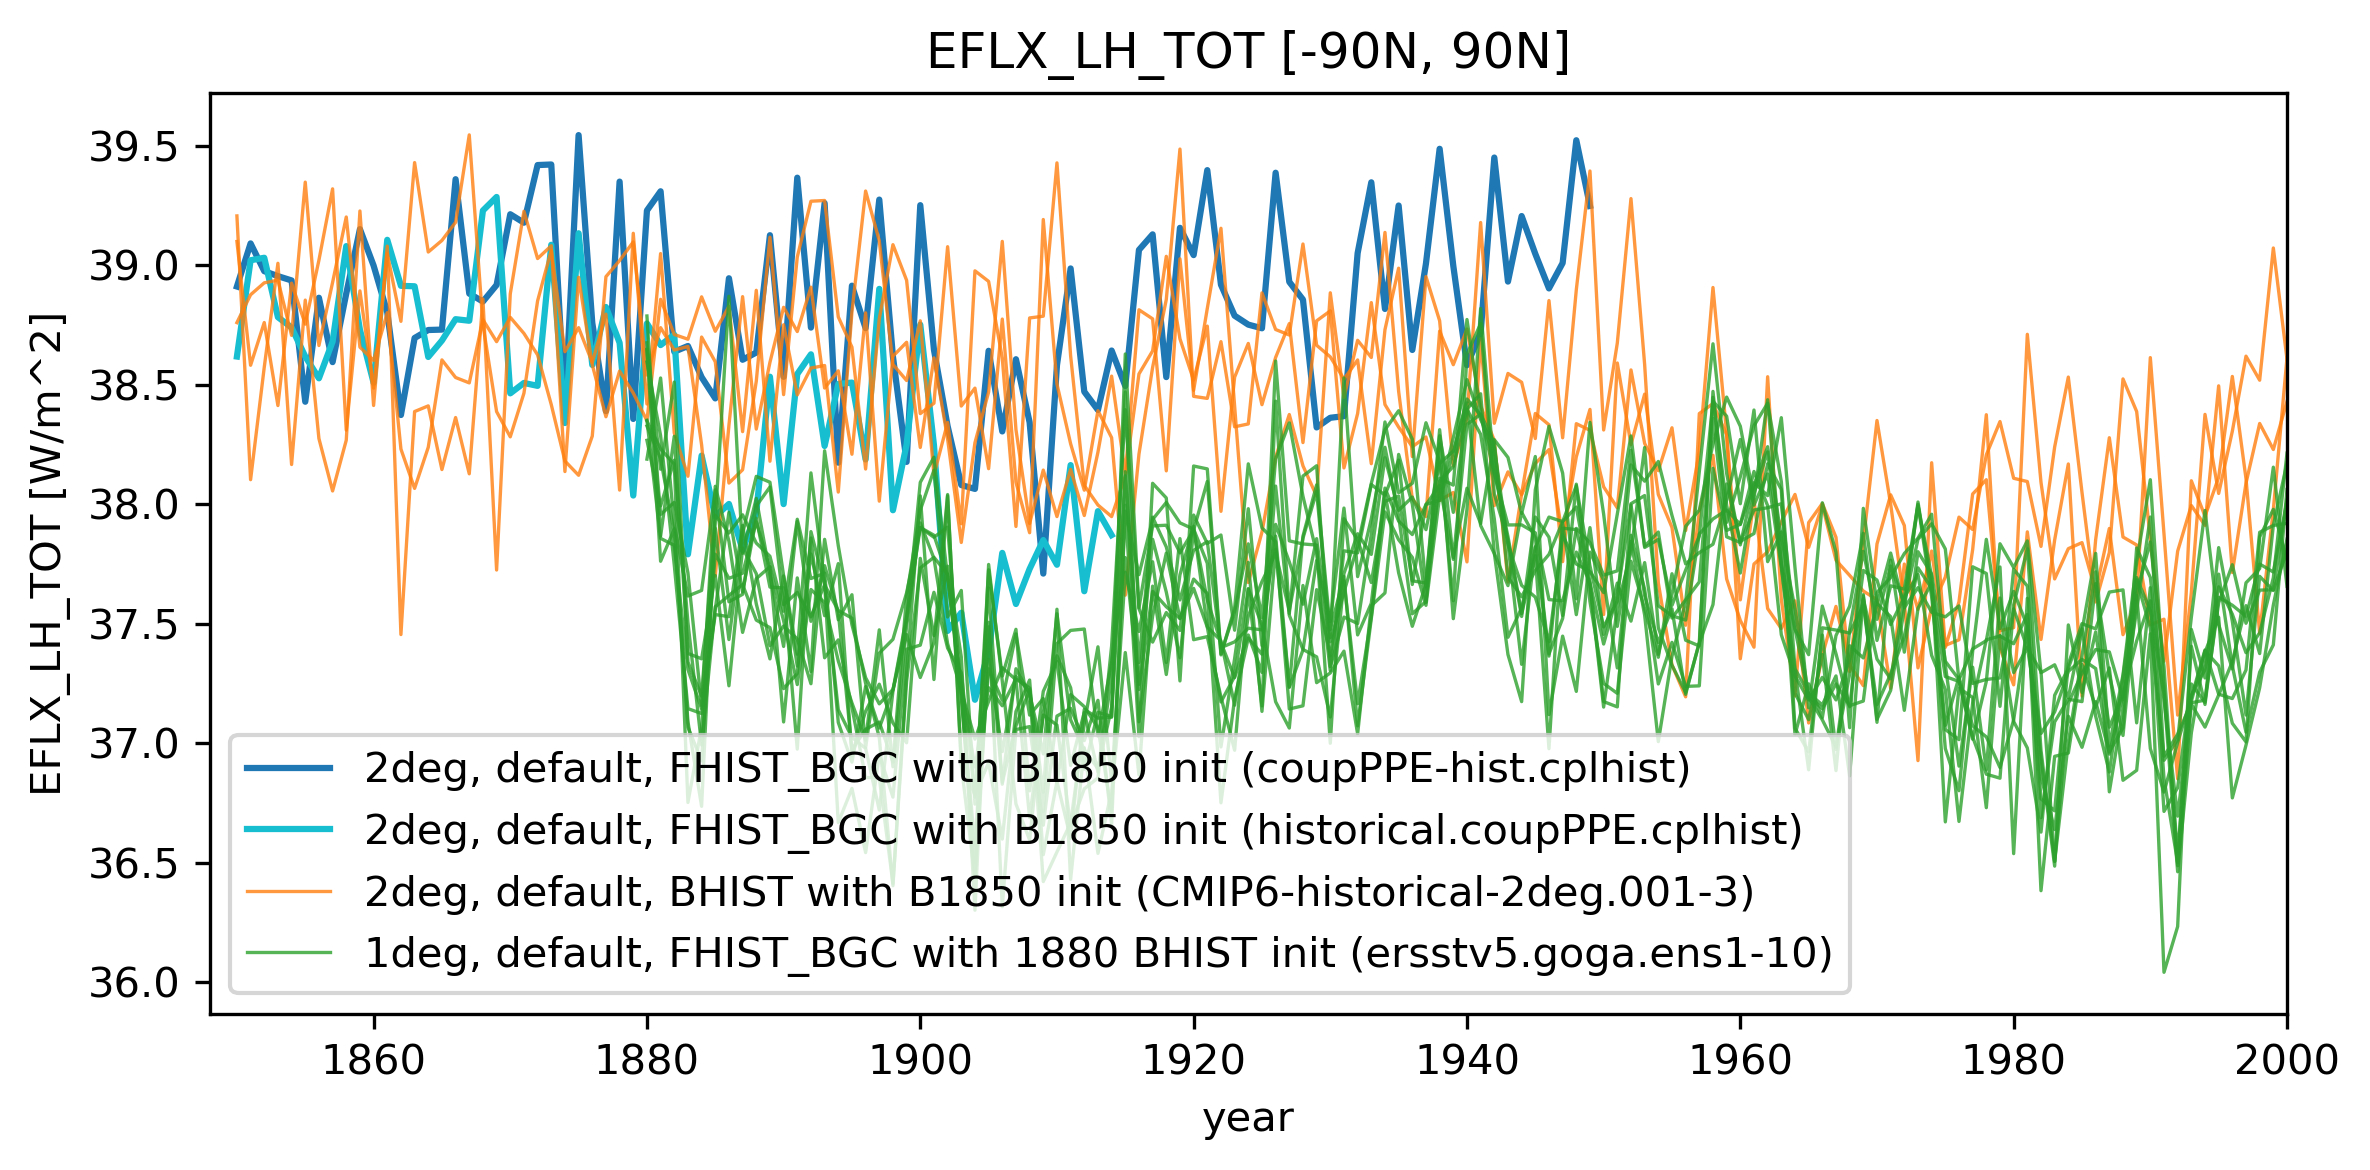

In [ ]:
lat_1 = -90
lat_2 = 90

srtyr = 1850
endyr = 2000

v = "EFLX_LH_TOT"

fig, ax = plt.subplots(figsize=(8, 4), dpi=300, layout="tight")

for i in range(3):
    label = None
    if i == 0:
        label = "2deg, default, BHIST with B1850 init (CMIP6-historical-2deg.001-3)"
    output[v]["b.e21.BHIST.f19_g17.CMIP6-historical-2deg"].sel(member=i, lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label=label, c="tab:orange", lw=0.8, alpha=0.8)

for i in range(10):
    label = None
    if i == 0:
        label = "1deg, default, FHIST_BGC with 1880 BHIST init (ersstv5.goga.ens1-10)"
    output[v]["f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.ens"].sel(member=i, lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg1).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label=label, c="tab:green", lw=0.8, alpha=0.8)

output[v]["f.e21.FHIST_BGC.f19_f19_mg17.coupPPE-hist.cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label="2deg, default, FHIST_BGC with B1850 init (coupPPE-hist.cplhist)",  c="tab:blue")
output[v]["f.e21.FHIST_BGC.f19_f19_mg17.historical.coupPPE.cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label="2deg, default, FHIST_BGC with B1850 init (historical.coupPPE.cplhist)",  c="tab:cyan")

ax.set_xlim(srtyr-2, endyr)
ax.set_ylabel("EFLX_LH_TOT [W/m^2]")
ax.set_title(f"{v} [{lat_1}N, {lat_2}N]")
ax.legend()

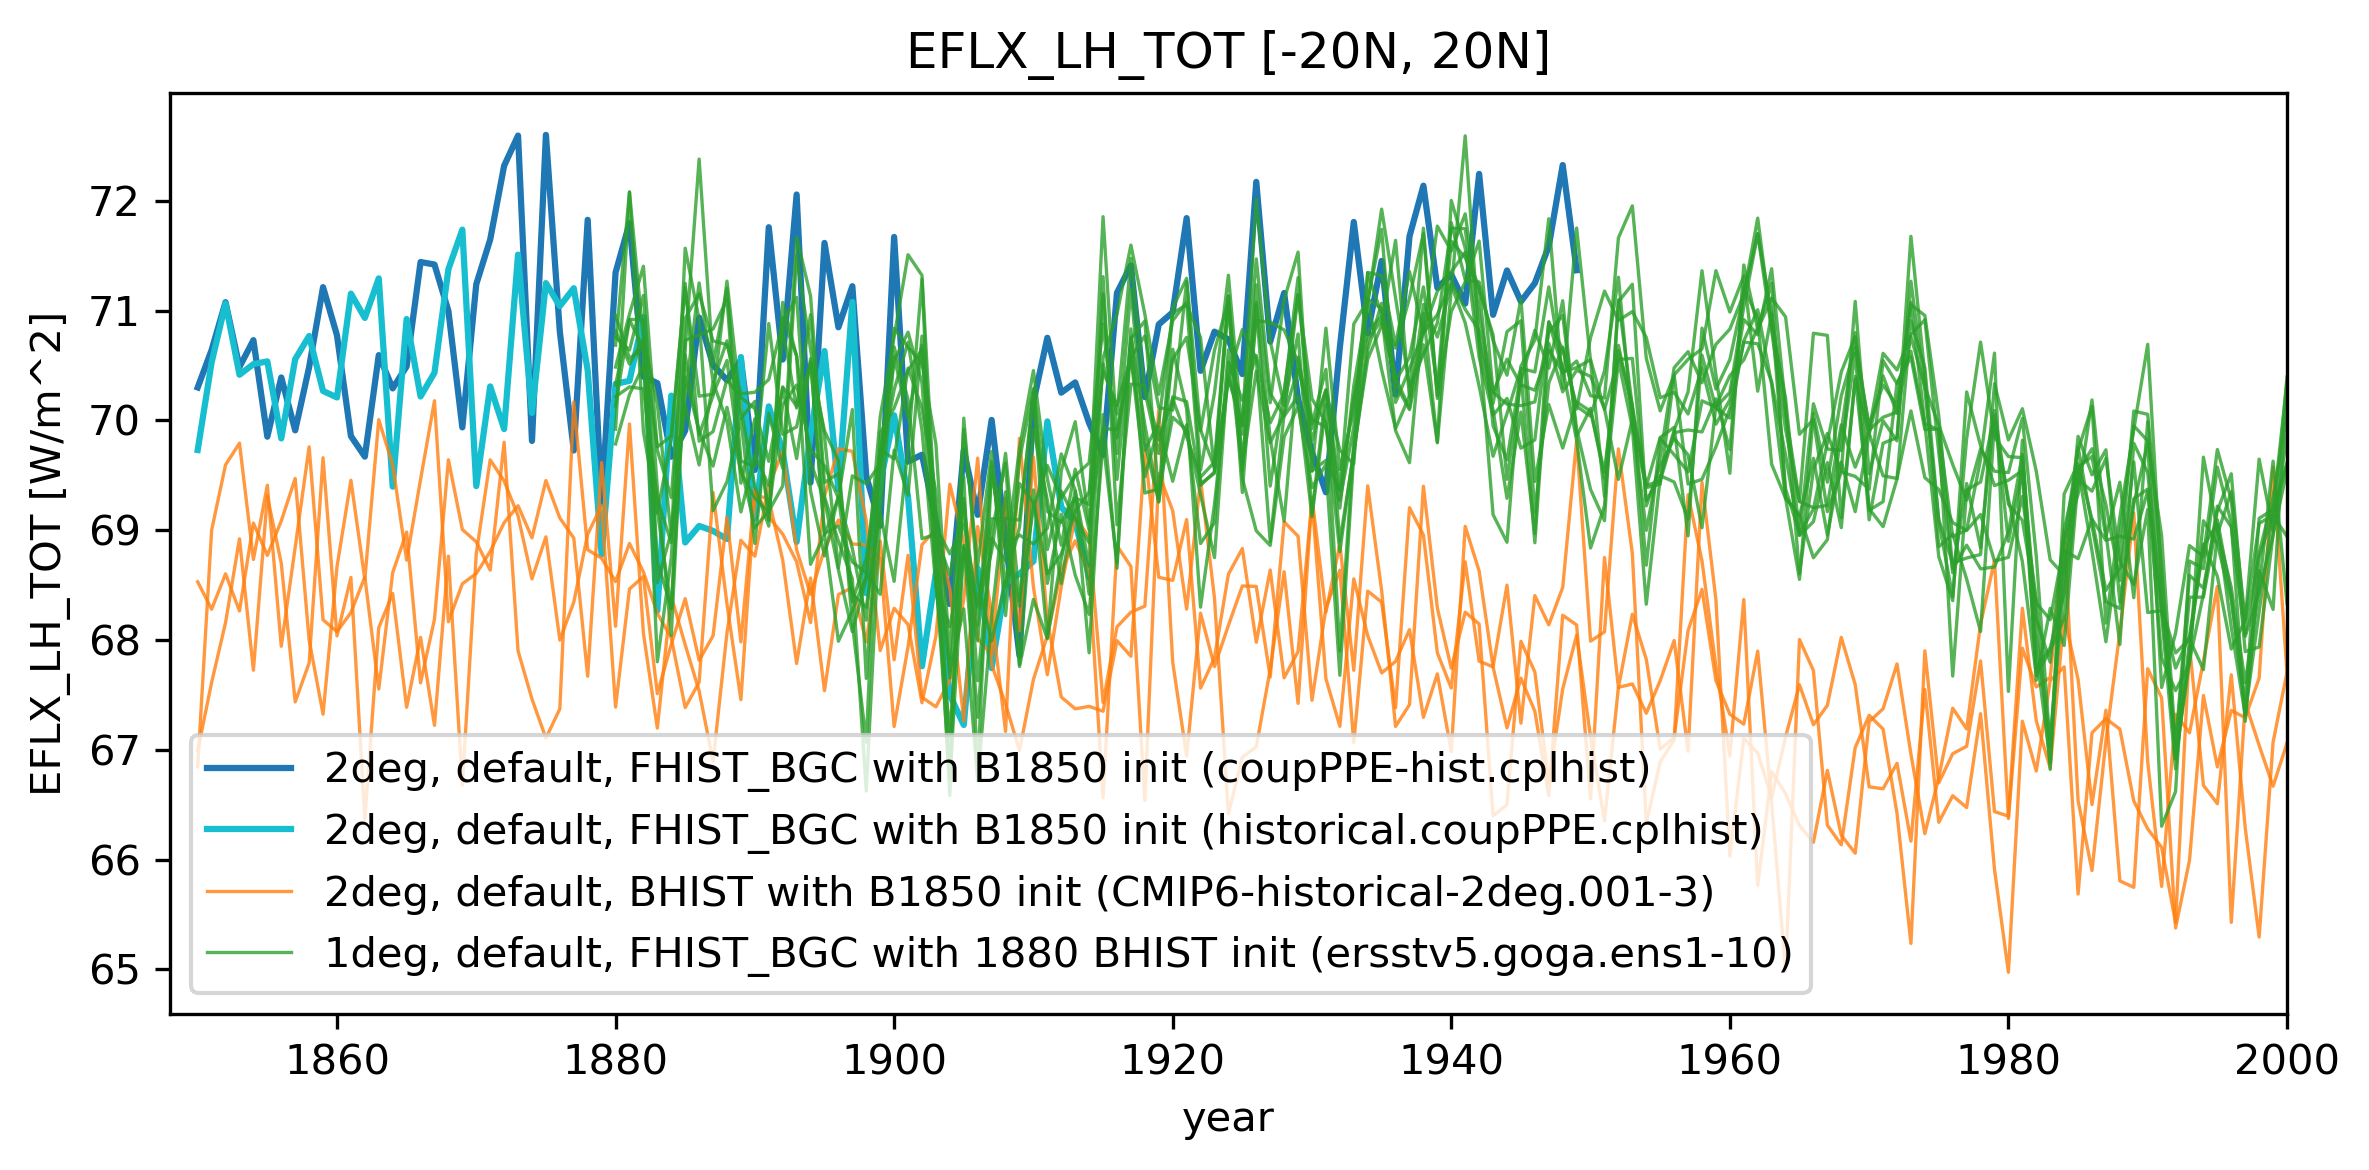

In [ ]:
lat_1 = -20
lat_2 = 20

srtyr = 1850
endyr = 2000

v = "EFLX_LH_TOT"

fig, ax = plt.subplots(figsize=(8, 4), dpi=300, layout="tight")

for i in range(3):
    label = None
    if i == 0:
        label = "2deg, default, BHIST with B1850 init (CMIP6-historical-2deg.001-3)"
    output[v]["b.e21.BHIST.f19_g17.CMIP6-historical-2deg"].sel(member=i, lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label=label, c="tab:orange", lw=0.8, alpha=0.8)

for i in range(10):
    label = None
    if i == 0:
        label = "1deg, default, FHIST_BGC with 1880 BHIST init (ersstv5.goga.ens1-10)"
    output[v]["f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.ens"].sel(member=i, lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg1).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label=label, c="tab:green", lw=0.8, alpha=0.8)

output[v]["f.e21.FHIST_BGC.f19_f19_mg17.coupPPE-hist.cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label="2deg, default, FHIST_BGC with B1850 init (coupPPE-hist.cplhist)",  c="tab:blue")
output[v]["f.e21.FHIST_BGC.f19_f19_mg17.historical.coupPPE.cplhist"].sel(lat=slice(lat_1, lat_2), time=slice(f"{srtyr}-01", f"{endyr}-12")).weighted(la_deg2).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, label="2deg, default, FHIST_BGC with B1850 init (historical.coupPPE.cplhist)",  c="tab:cyan")

ax.set_xlim(srtyr-2, endyr)
ax.set_ylabel("EFLX_LH_TOT [W/m^2]")
ax.set_title(f"{v} [{lat_1}N, {lat_2}N]")
ax.legend()

In [78]:
client.shutdown()
del cluster
del client
!rm ./dask-worker.e*
!rm ./dask-worker.o*